In [1]:
import botorch
import gpytorch
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

plt.style.use("fivethirtyeight")
plt.rc("figure", figsize=(16, 8))

In [2]:
# %load bo.py
import matplotlib.pyplot as plt
import torch

# Customize plot.
plt.style.use("fivethirtyeight")
plt.rc("figure", figsize=(16, 8))


def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)


def ackley(x):
    # a modification of https://www.sfu.ca/~ssurjano/ackley.html
    return -20 * torch.exp(
        -0.2 * torch.sqrt((x[:, 0] ** 2 + x[:, 1] ** 2) / 2)
    ) - torch.exp(torch.cos(2 * pi * x[:, 0] / 3) + torch.cos(2 * pi * x[:, 1]))


def visualize_gp_belief(model, likelihood, num_samples=5):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

    plt.figure(figsize=(8, 6))

    plt.plot(xs, ys, label="objective", c="r")
    plt.scatter(train_x, train_y, marker="x", c="k", label="observation")

    plt.plot(xs, predictive_mean, label="mean")
    plt.fill_between(
        xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
    )

    torch.manual_seed(0)
    for i in range(num_samples):
        plt.plot(xs, predictive_distribution.sample(), alpha=0.5, linewidth=2)

    plt.legend(fontsize=15)
    plt.show()


def visualize_gp_belief_and_policy(
    model,
    likelihood,
    policy=None,
    next_x=None,
    xs=None,
    ys=None,
    train_x=None,
    train_y=None,
):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

        if policy is not None:
            acquisition_score = policy(xs.unsqueeze(1))

    if policy is None:
        plt.figure(figsize=(16, 6))
        plt.plot(xs, ys, label="objective", c="r")
        plt.scatter(train_x, train_y, marker="x", c="k", label="observations")
        plt.plot(xs, predictive_mean, label="mean")
        plt.fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )
        plt.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(
            2, 1, figsize=(16, 12), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
        )

        # GP belief
        ax[0].plot(xs, ys, label="objective", c="r")
        ax[0].scatter(train_x, train_y, marker="x", c="k", label="observations")
        ax[0].plot(xs, predictive_mean, label="mean")
        ax[0].fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        if next_x is not None:
            ax[0].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[0].legend()
        ax[0].set_ylabel("predictive")

        # Acquisition score
        ax[1].plot(xs, acquisition_score, c="g")
        ax[1].fill_between(xs.flatten(), acquisition_score, 0, color="g", alpha=0.5)

        if next_x is not None:
            ax[1].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[1].set_ylabel("acquisition core")
        plt.show()

        pass


def visualize_improvement(acquisition_fn, **kwargs):
    num_queries = 10
    bound = 5

    xs = torch.linspace(-bound, bound, bound * 100 + 1).unsqueeze(1)
    ys = forrester_1d(xs)

    train_x = torch.tensor([[1.0], [2.0]])
    train_y = forrester_1d(train_x)

    for i in range(num_queries):
        print("iteration", i)
        print("incumbent", train_x[train_y.argmax()], train_y.max())

        model, likelihood = fit_gp_model(train_x, train_y)

        if acquisition_fn == "pi":
            policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
                model, best_f=train_y.max()
            )
        elif acquisition_fn == "ei":
            policy = botorch.acquisition.analytic.LogExpectedImprovement(
                model, best_f=train_y.max()
            )
        elif acquisition_fn == "ucb":
            policy = botorch.acquisition.analytic.UpperConfidenceBound(
                model, **kwargs
            )  # beta=1
        else:
            raise NotImplementedError

        next_x, acq_val = botorch.optim.optimize_acqf(
            policy,
            bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
            q=1,
            num_restarts=20,
            raw_samples=50,
        )

        visualize_gp_belief_and_policy(
            model,
            likelihood,
            policy,
            next_x=next_x,
            xs=xs,
            ys=ys,
            train_x=train_x,
            train_y=train_y,
        )

        next_y = forrester_1d(next_x)

        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])


def fit_gp_model(train_x, train_y, num_train_iters=500):
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in tqdm(range(num_train_iters)):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood


class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

iteration 0
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

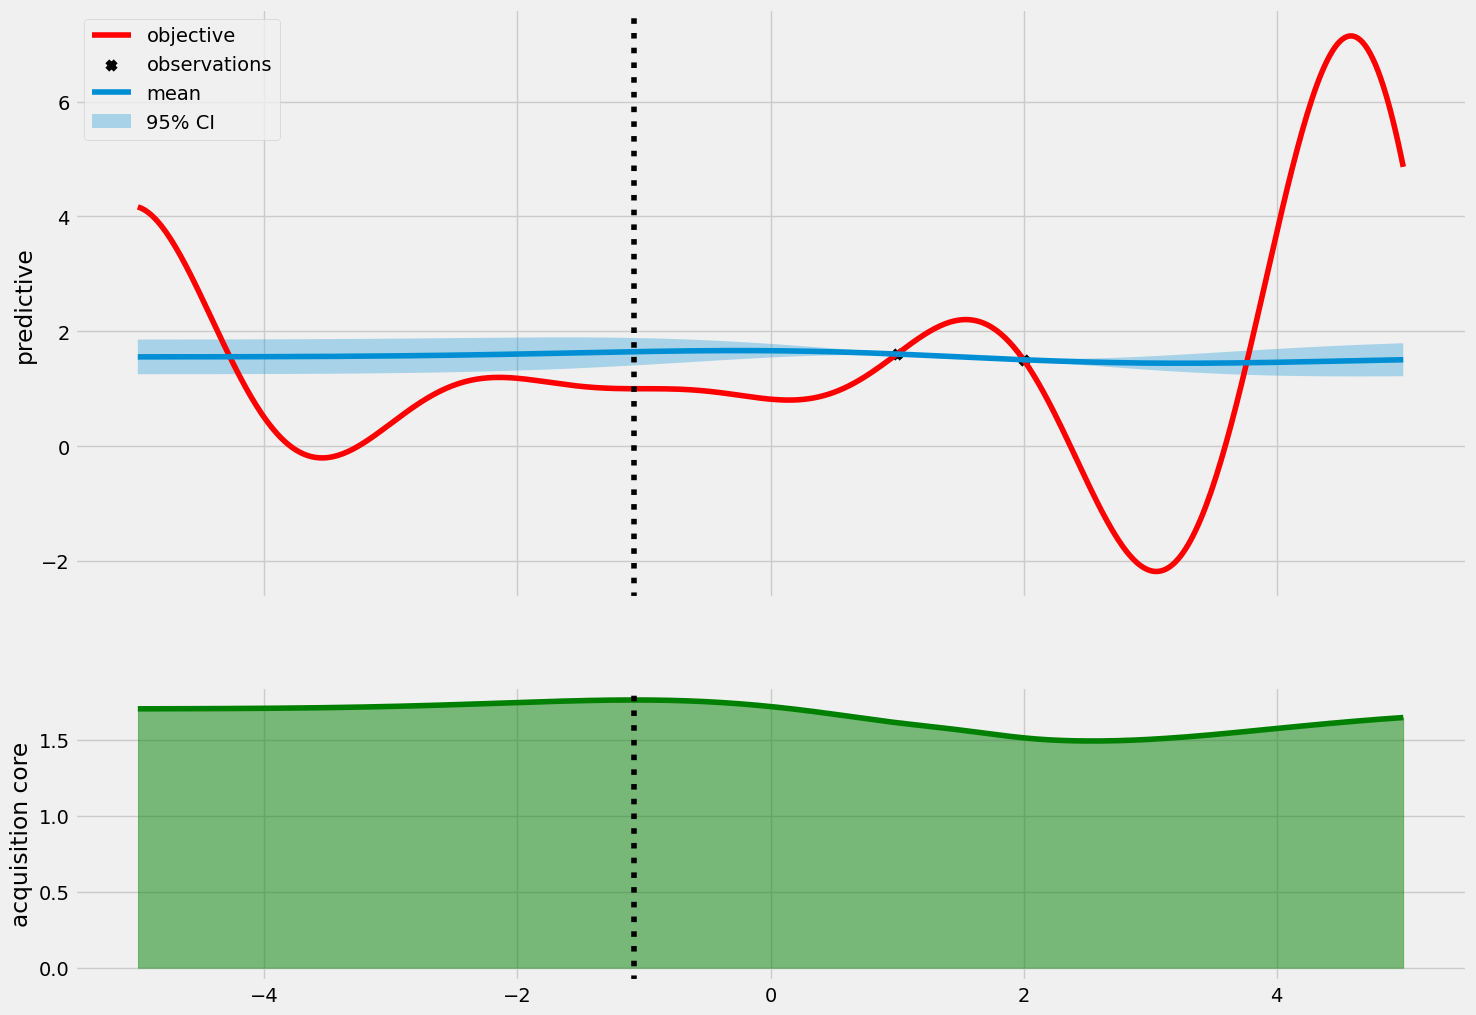

iteration 1
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

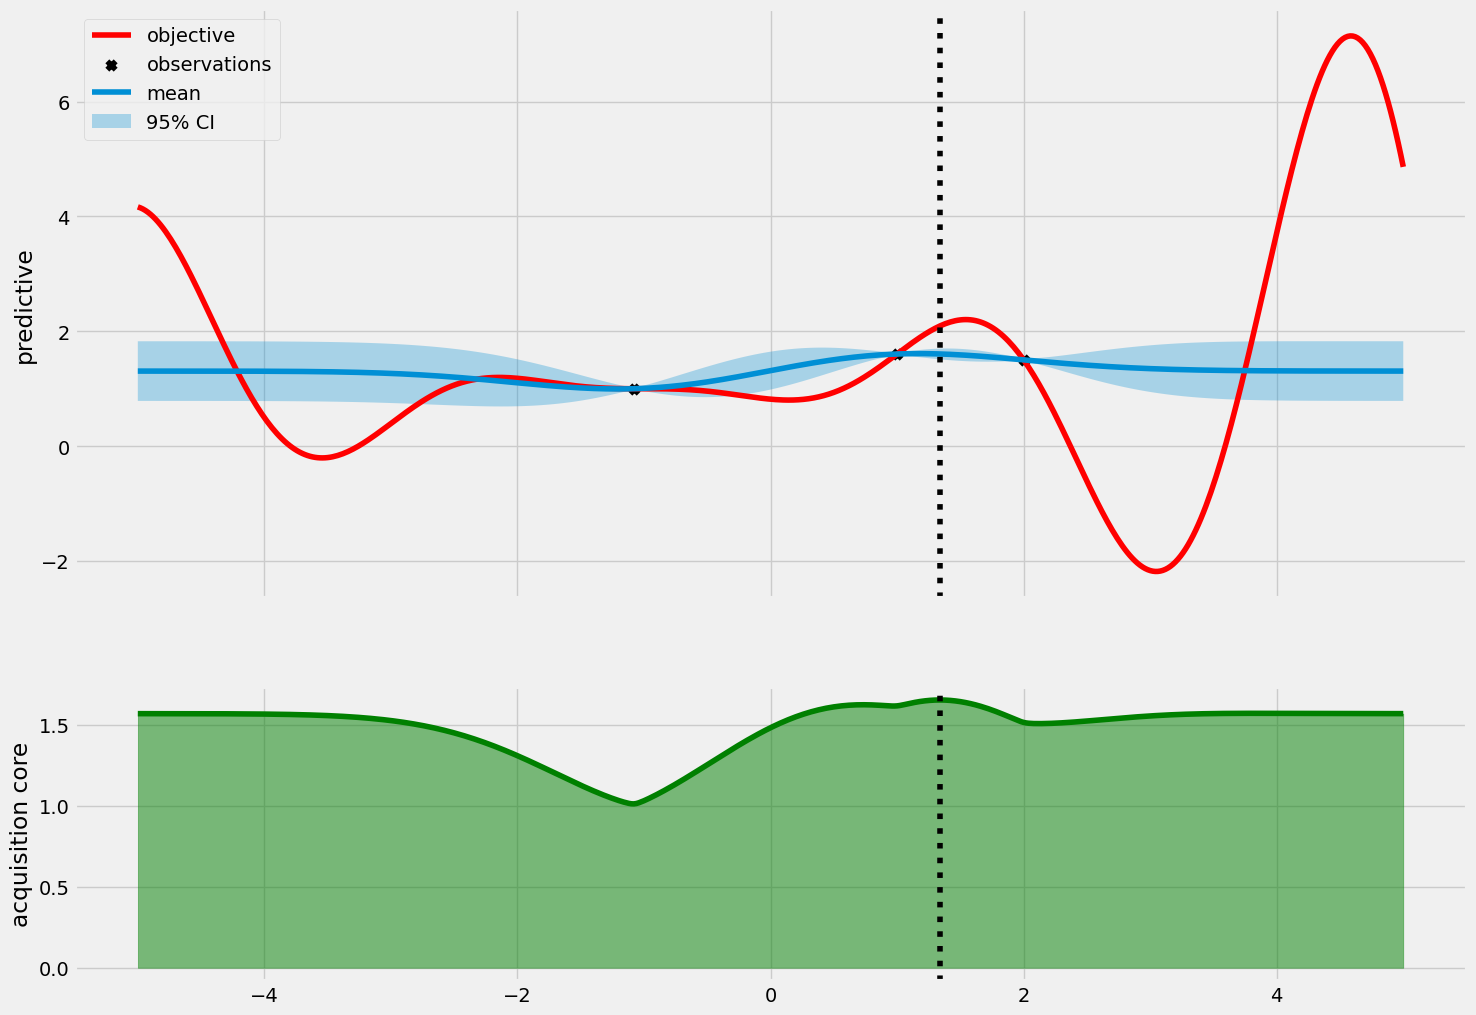

iteration 2
incumbent tensor([1.3374]) tensor(2.0919)


  0%|          | 0/500 [00:00<?, ?it/s]

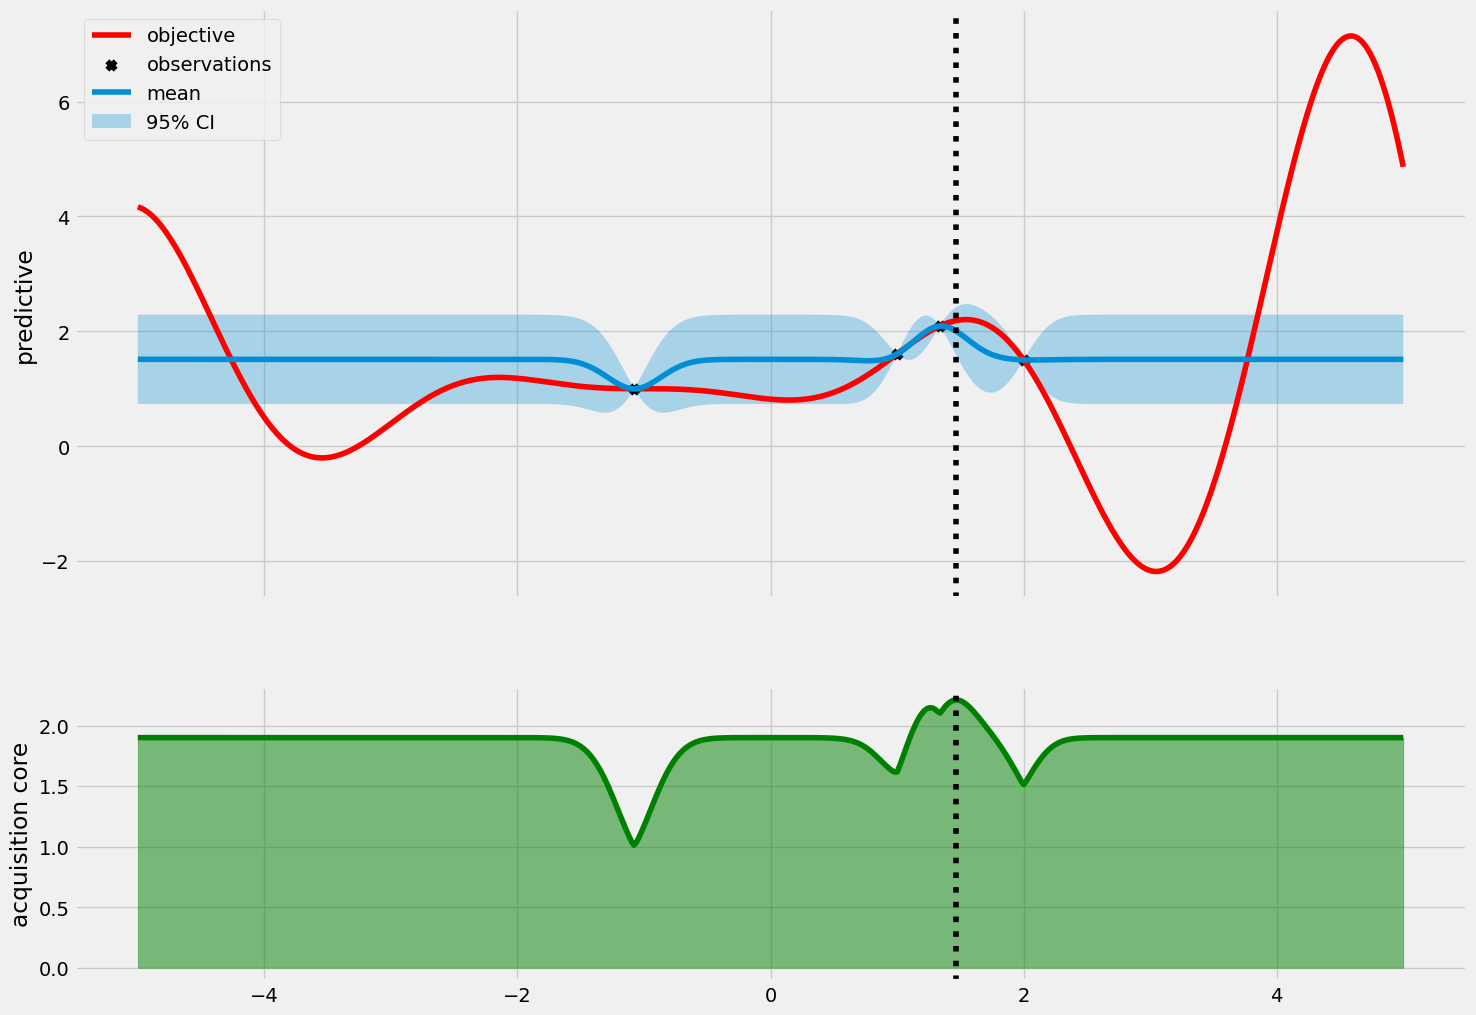

iteration 3
incumbent tensor([1.4682]) tensor(2.1879)


  0%|          | 0/500 [00:00<?, ?it/s]

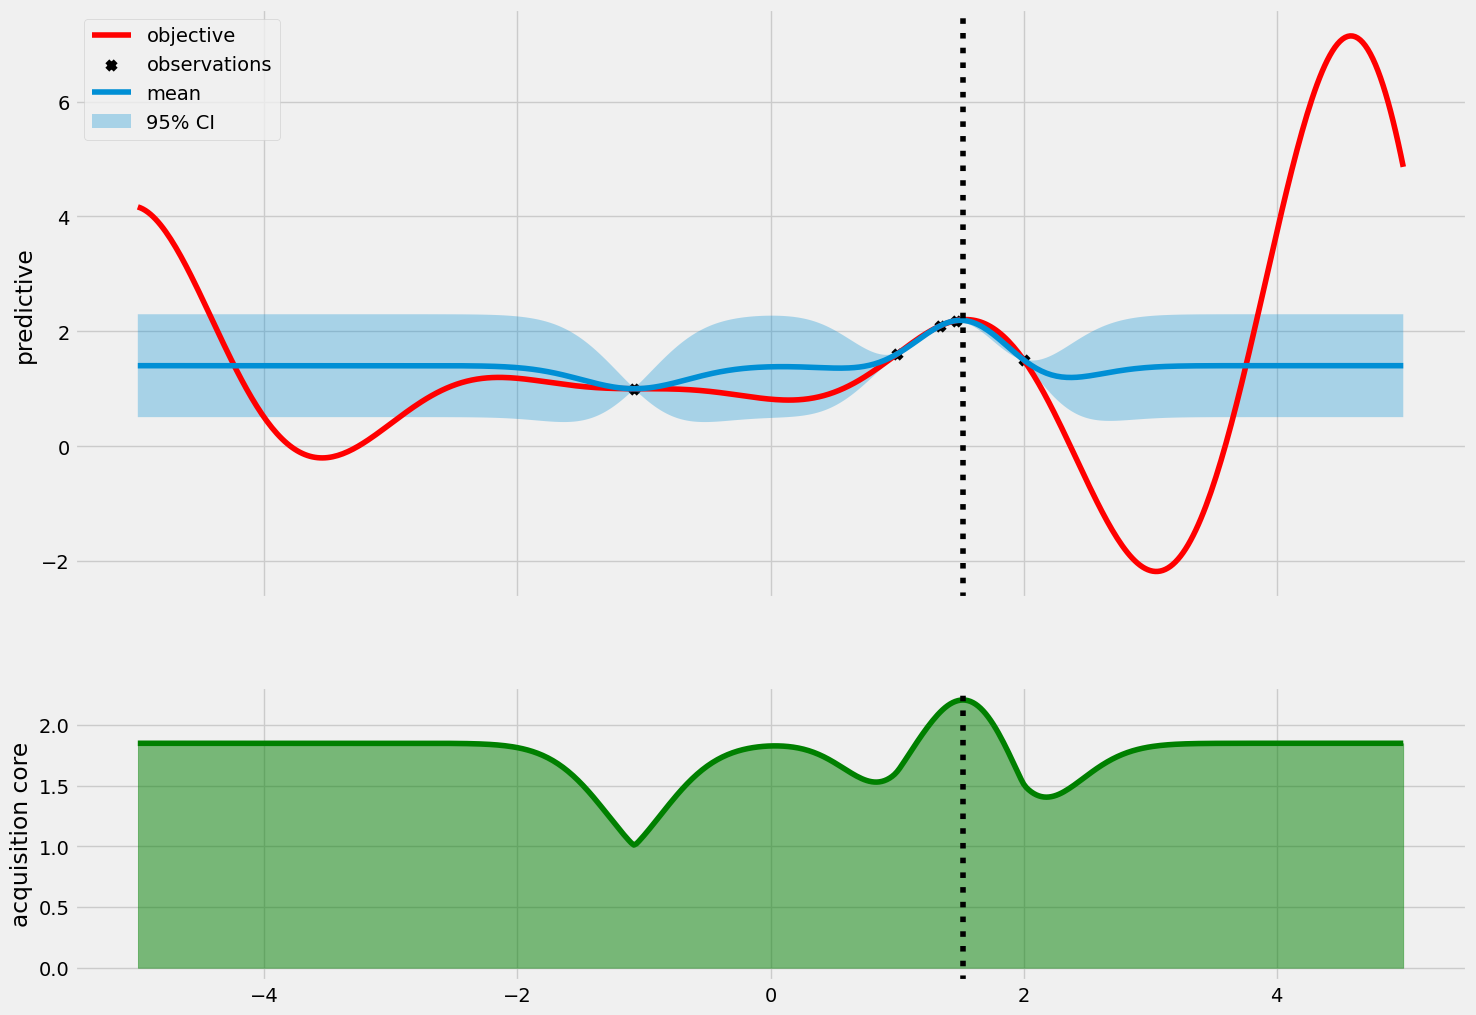

iteration 4
incumbent tensor([1.5211]) tensor(2.2027)


  0%|          | 0/500 [00:00<?, ?it/s]

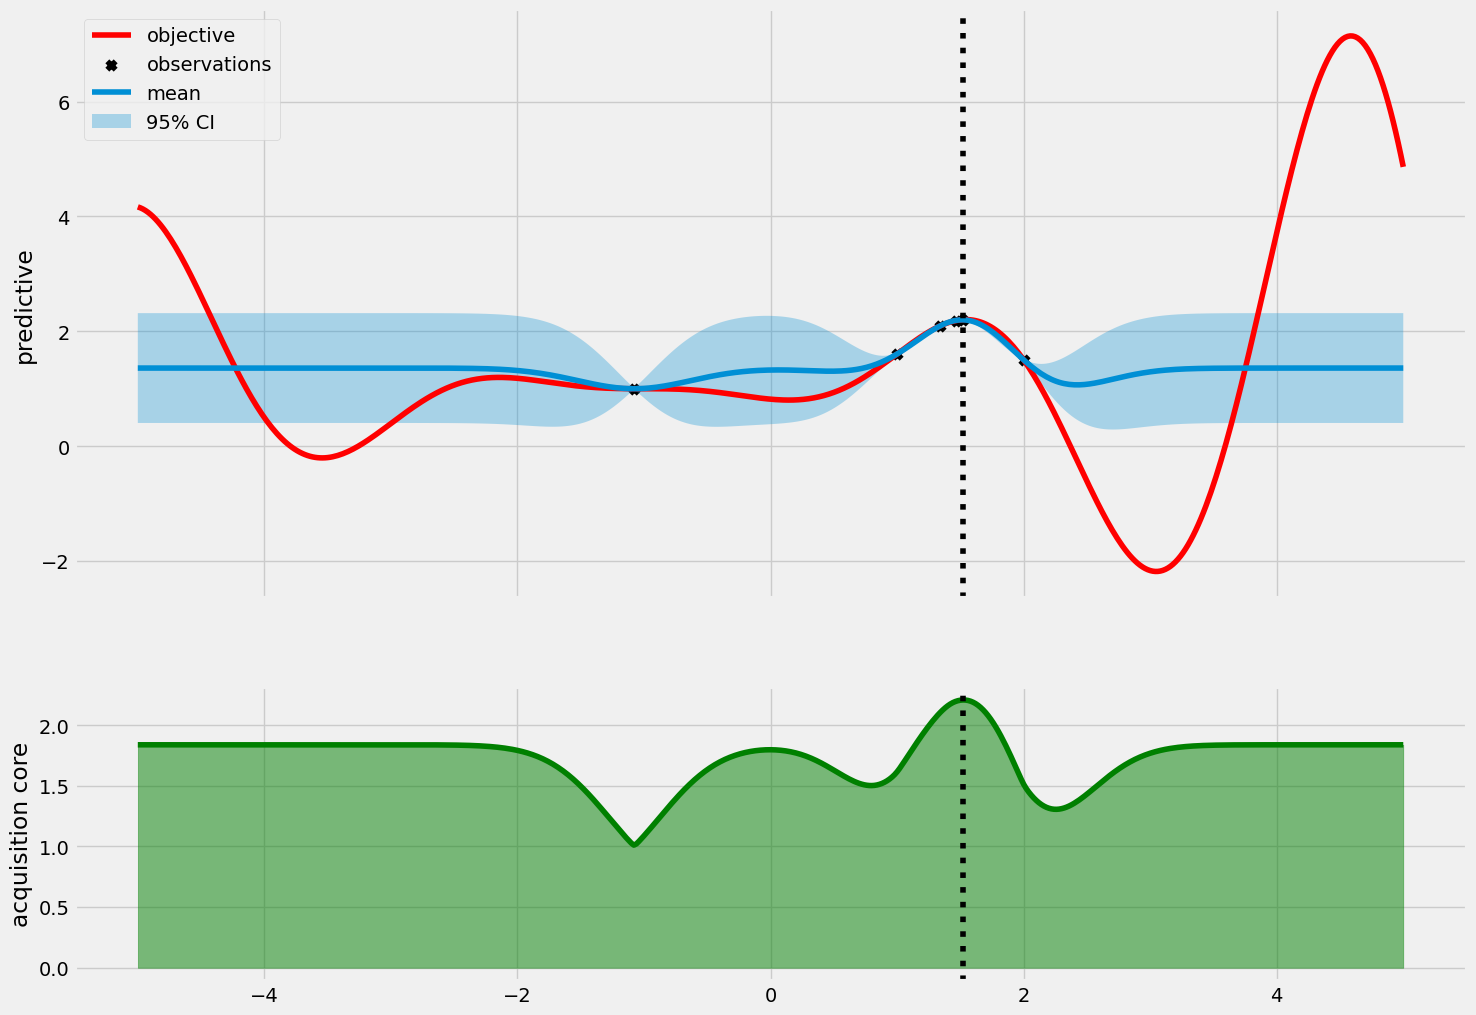

iteration 5
incumbent tensor([1.5247]) tensor(2.2031)


  0%|          | 0/500 [00:00<?, ?it/s]

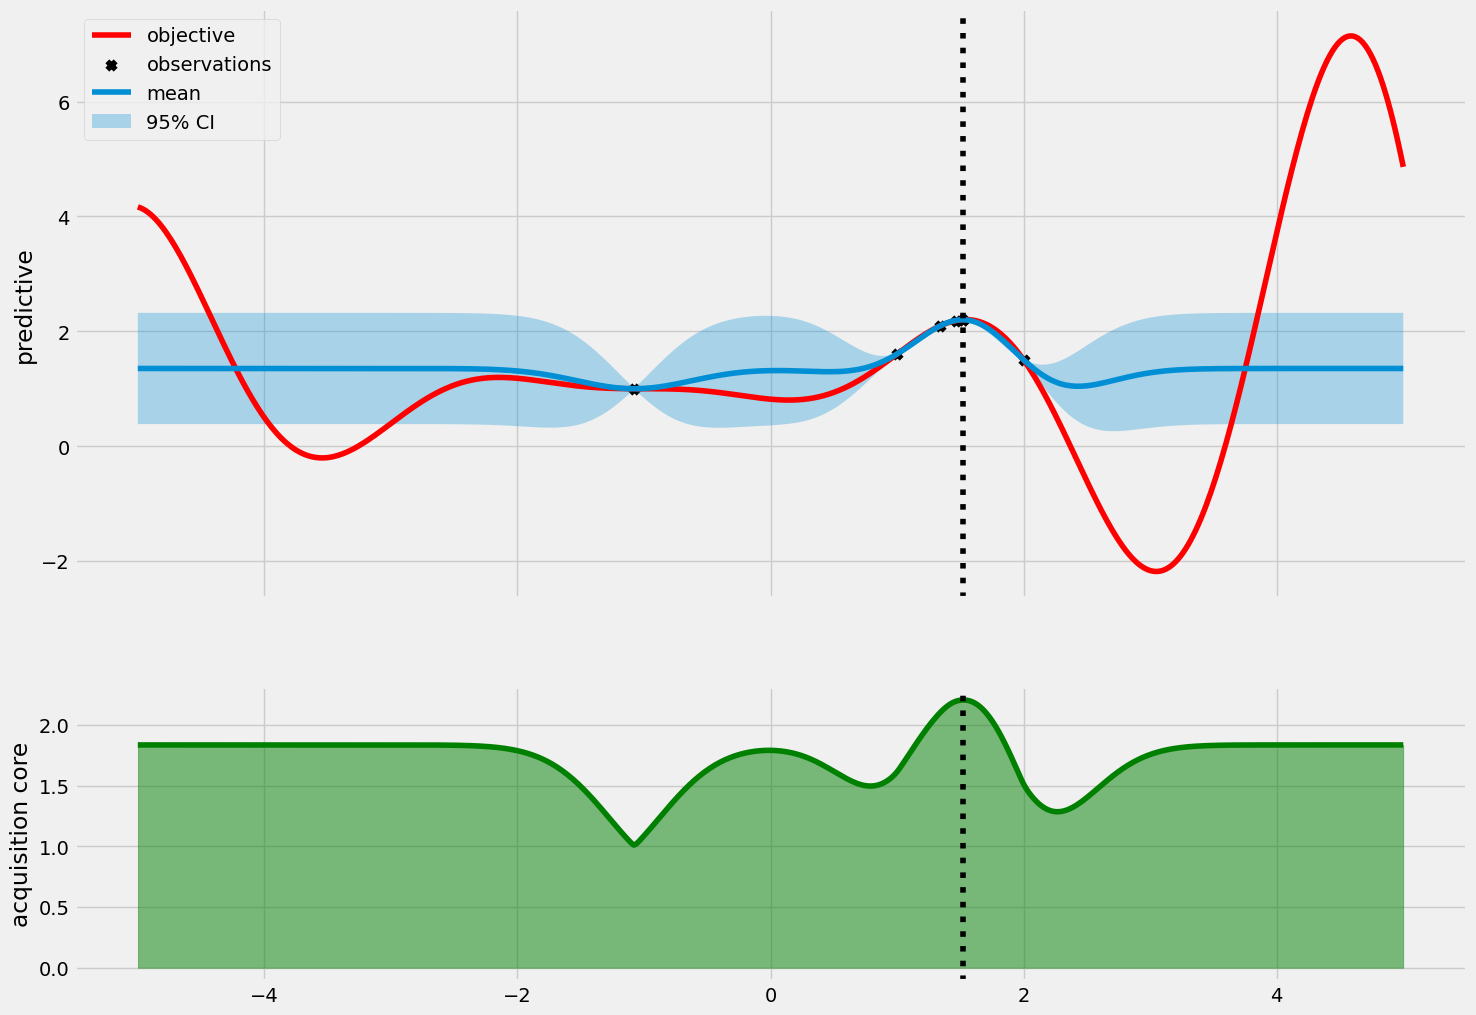

iteration 6
incumbent tensor([1.5247]) tensor(2.2031)


  0%|          | 0/500 [00:00<?, ?it/s]

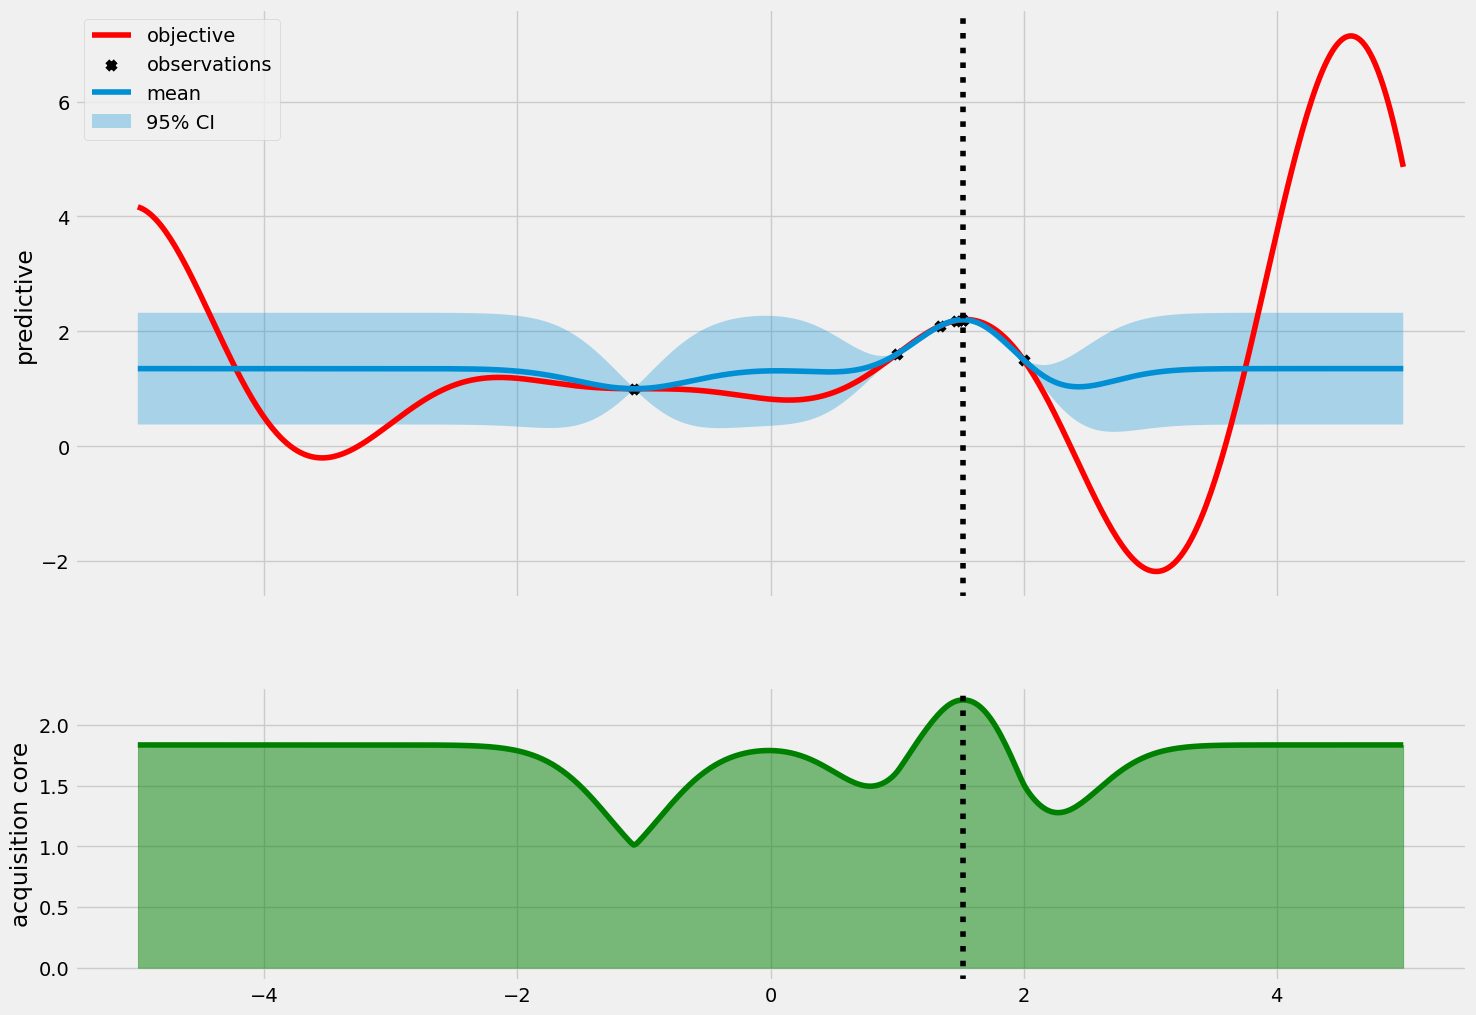

iteration 7
incumbent tensor([1.5247]) tensor(2.2031)


  0%|          | 0/500 [00:00<?, ?it/s]

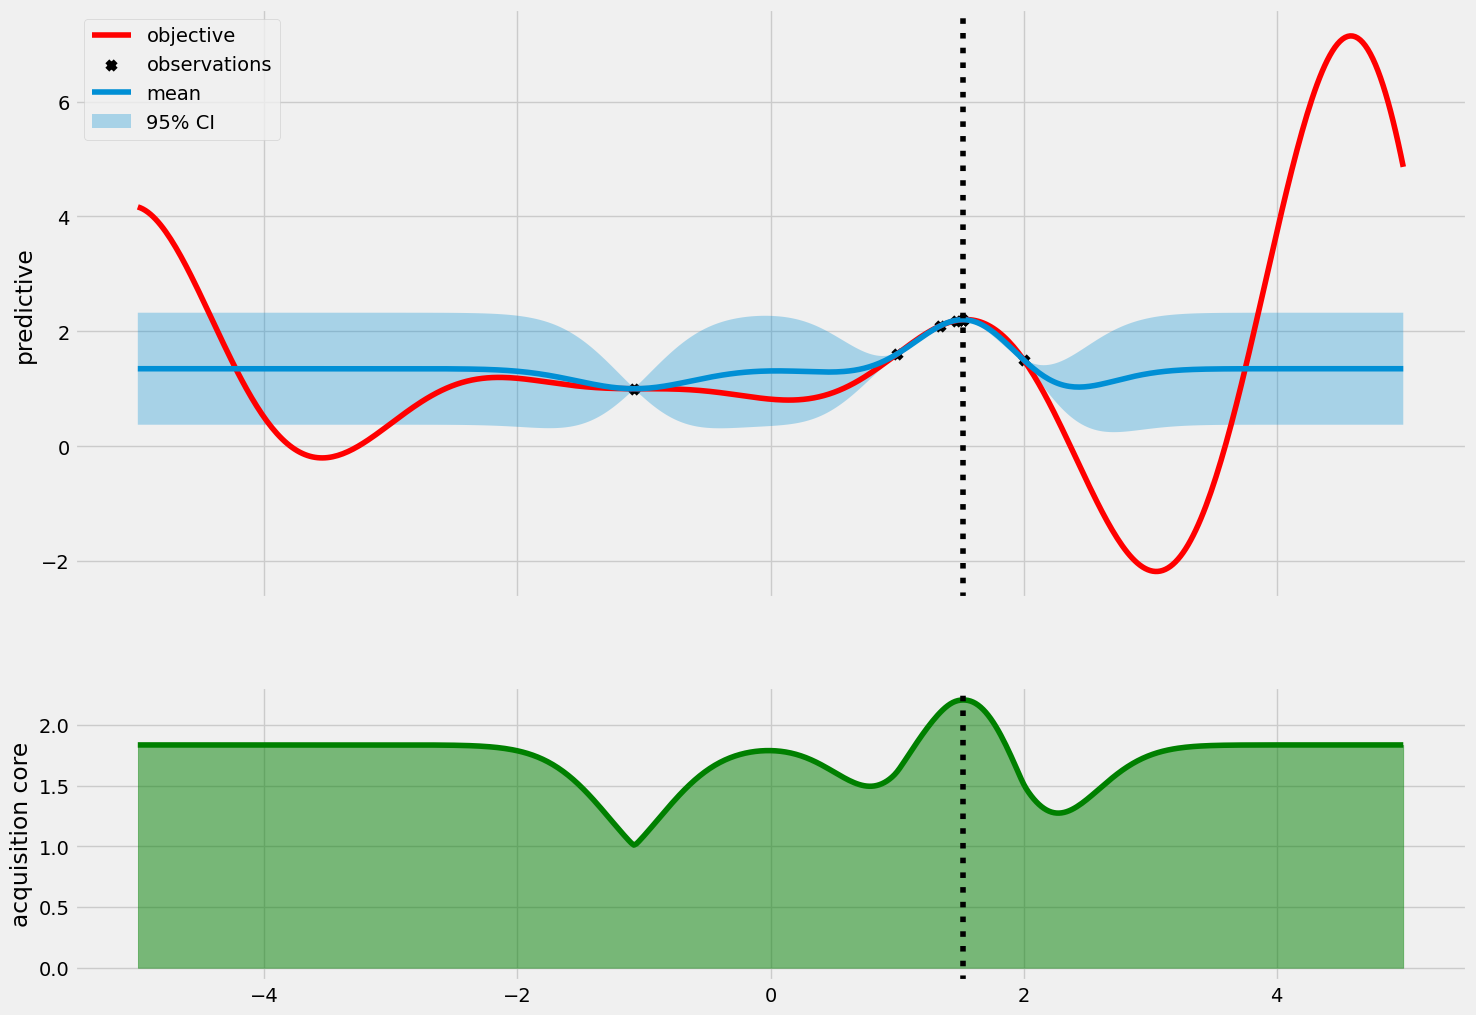

iteration 8
incumbent tensor([1.5247]) tensor(2.2031)


  0%|          | 0/500 [00:00<?, ?it/s]

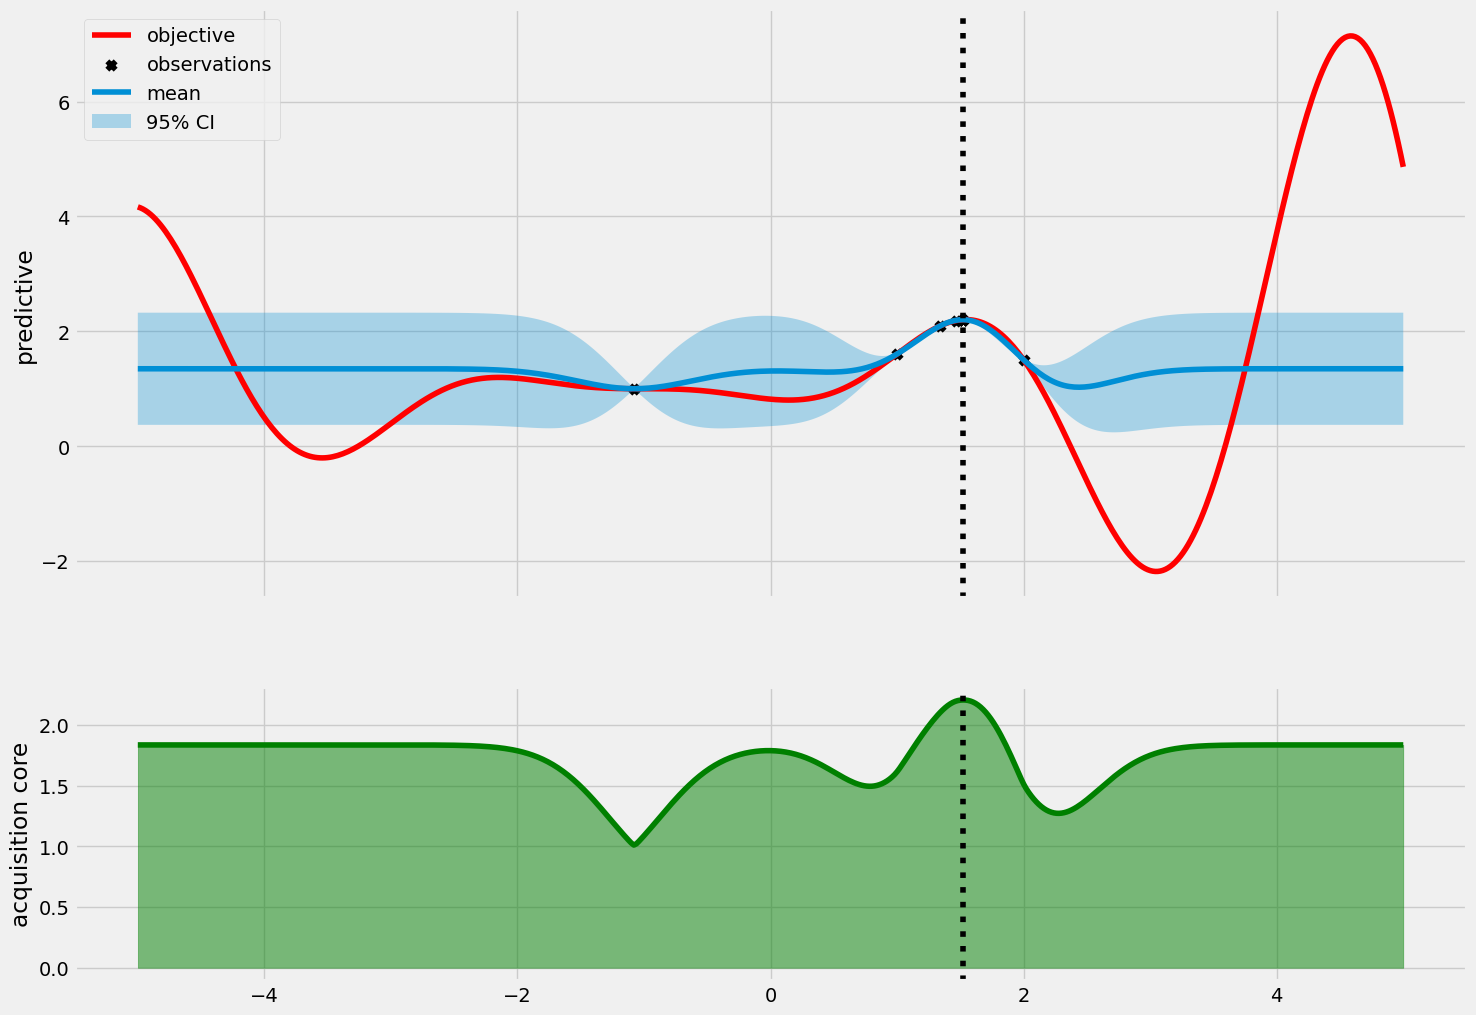

iteration 9
incumbent tensor([1.5247]) tensor(2.2031)


  0%|          | 0/500 [00:00<?, ?it/s]

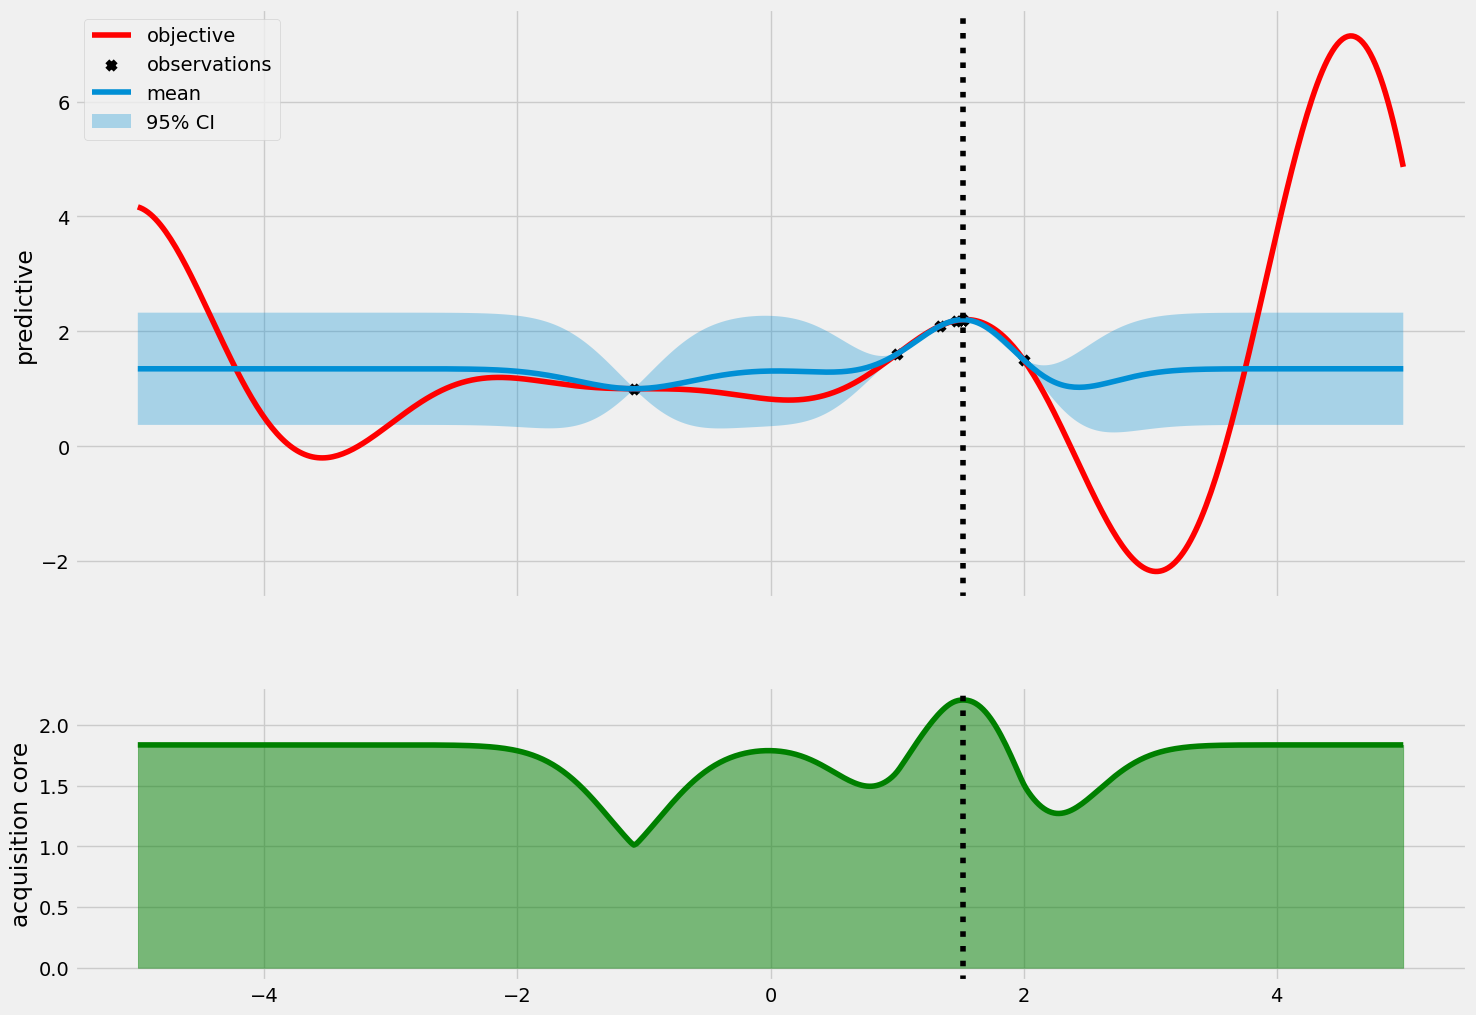

In [3]:
visualize_improvement("ucb", beta=1)

iteration 0
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

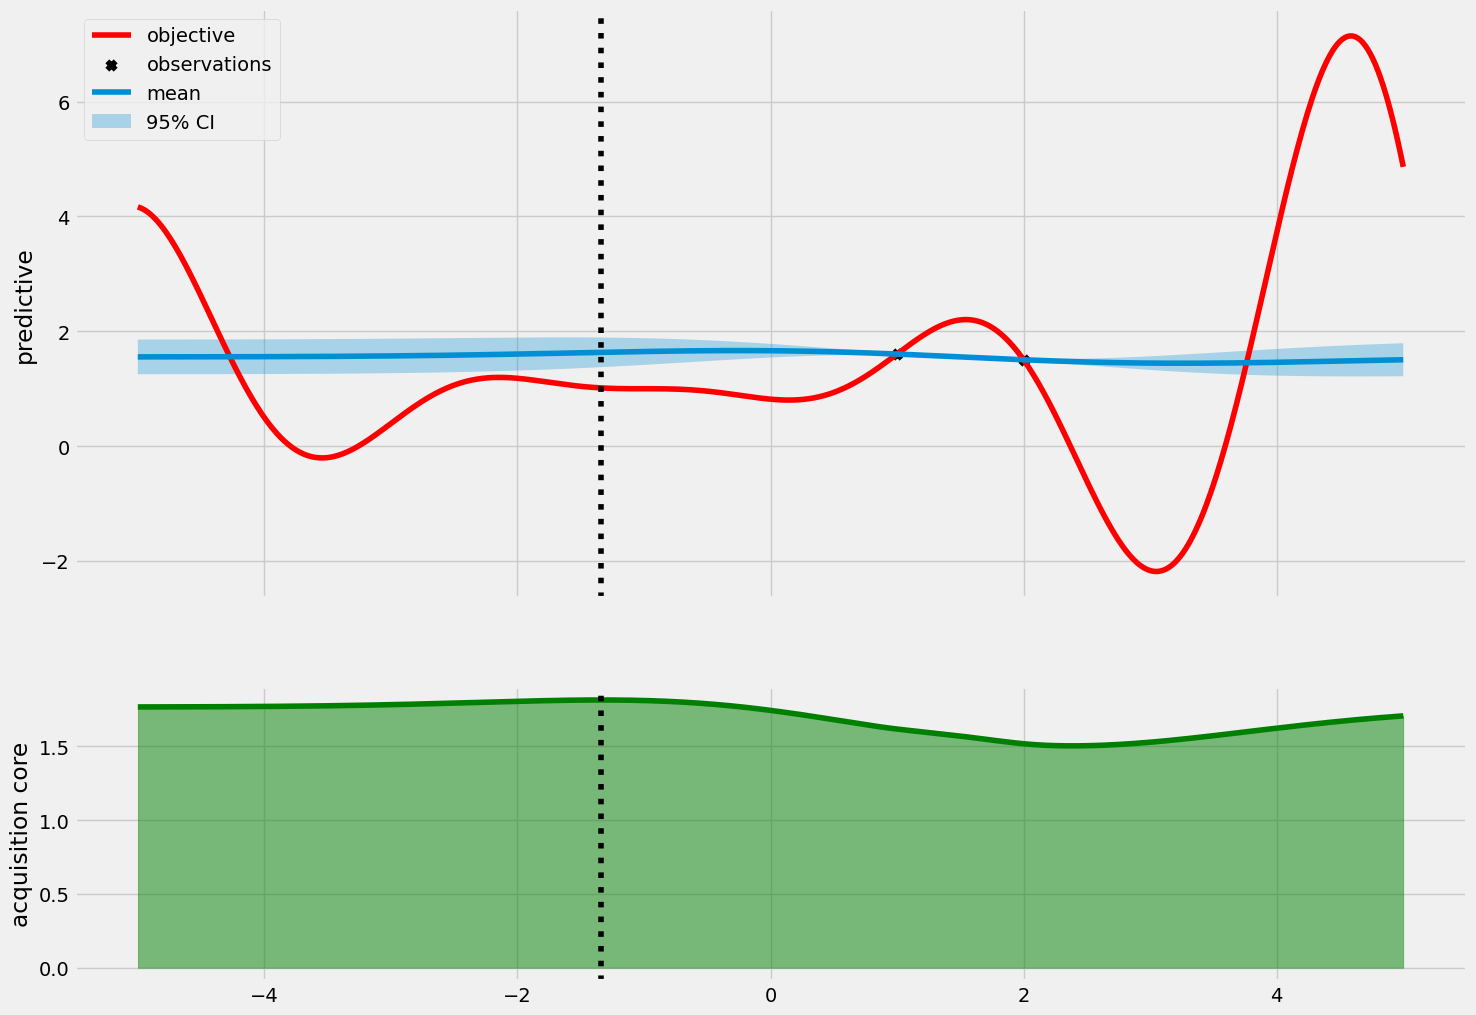

iteration 1
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

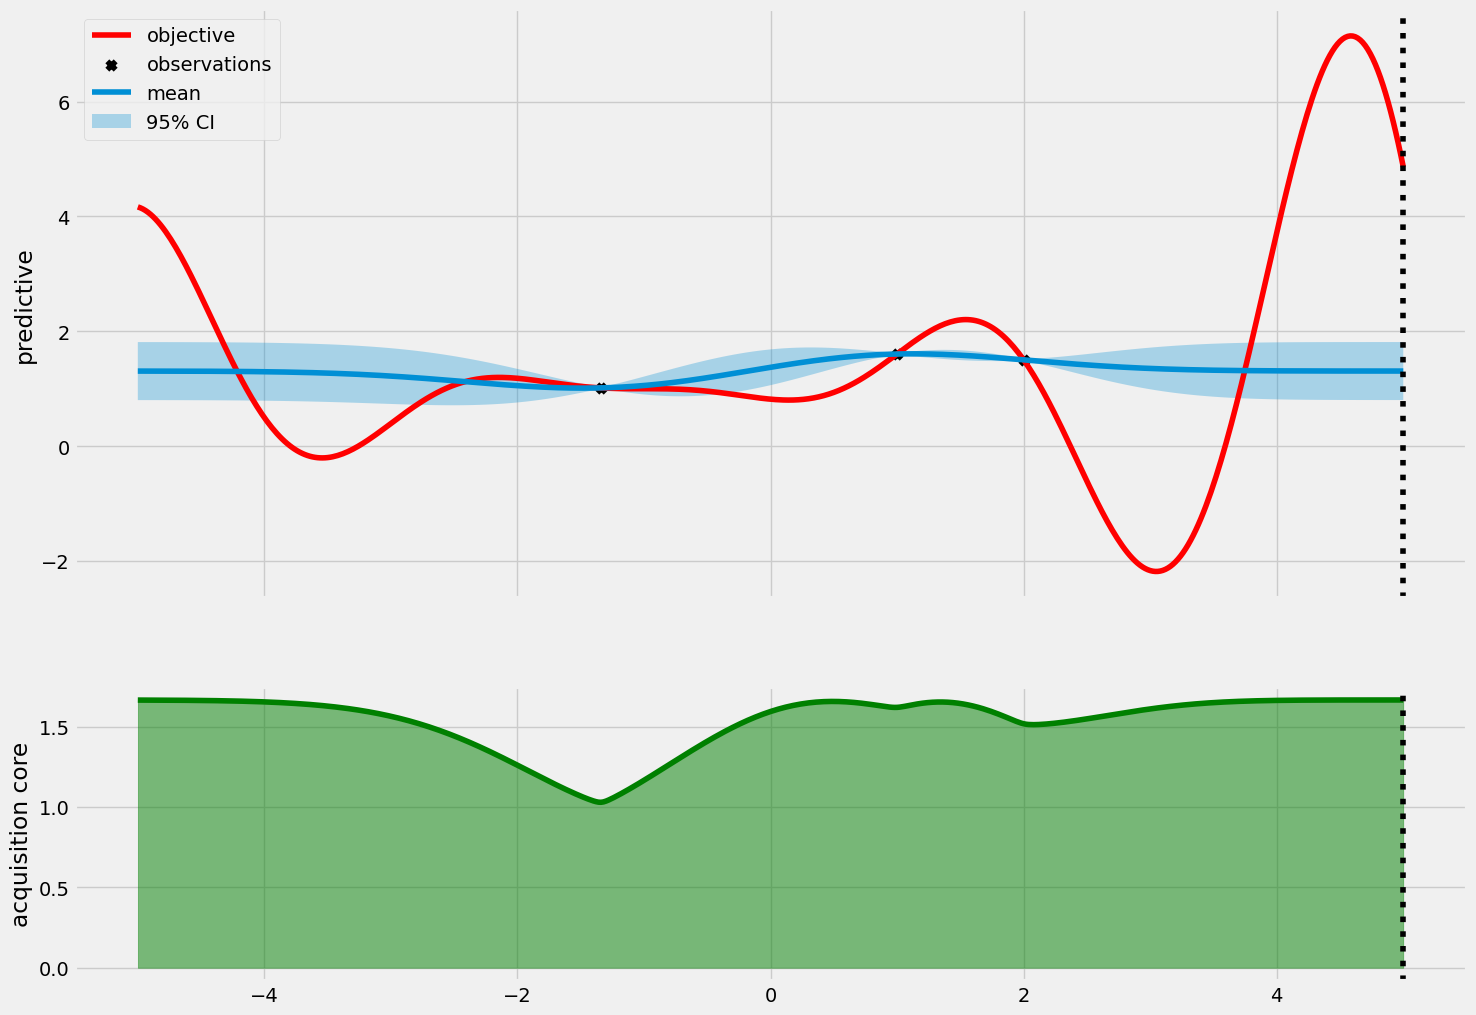

iteration 2
incumbent tensor([5.]) tensor(4.8633)


  0%|          | 0/500 [00:00<?, ?it/s]

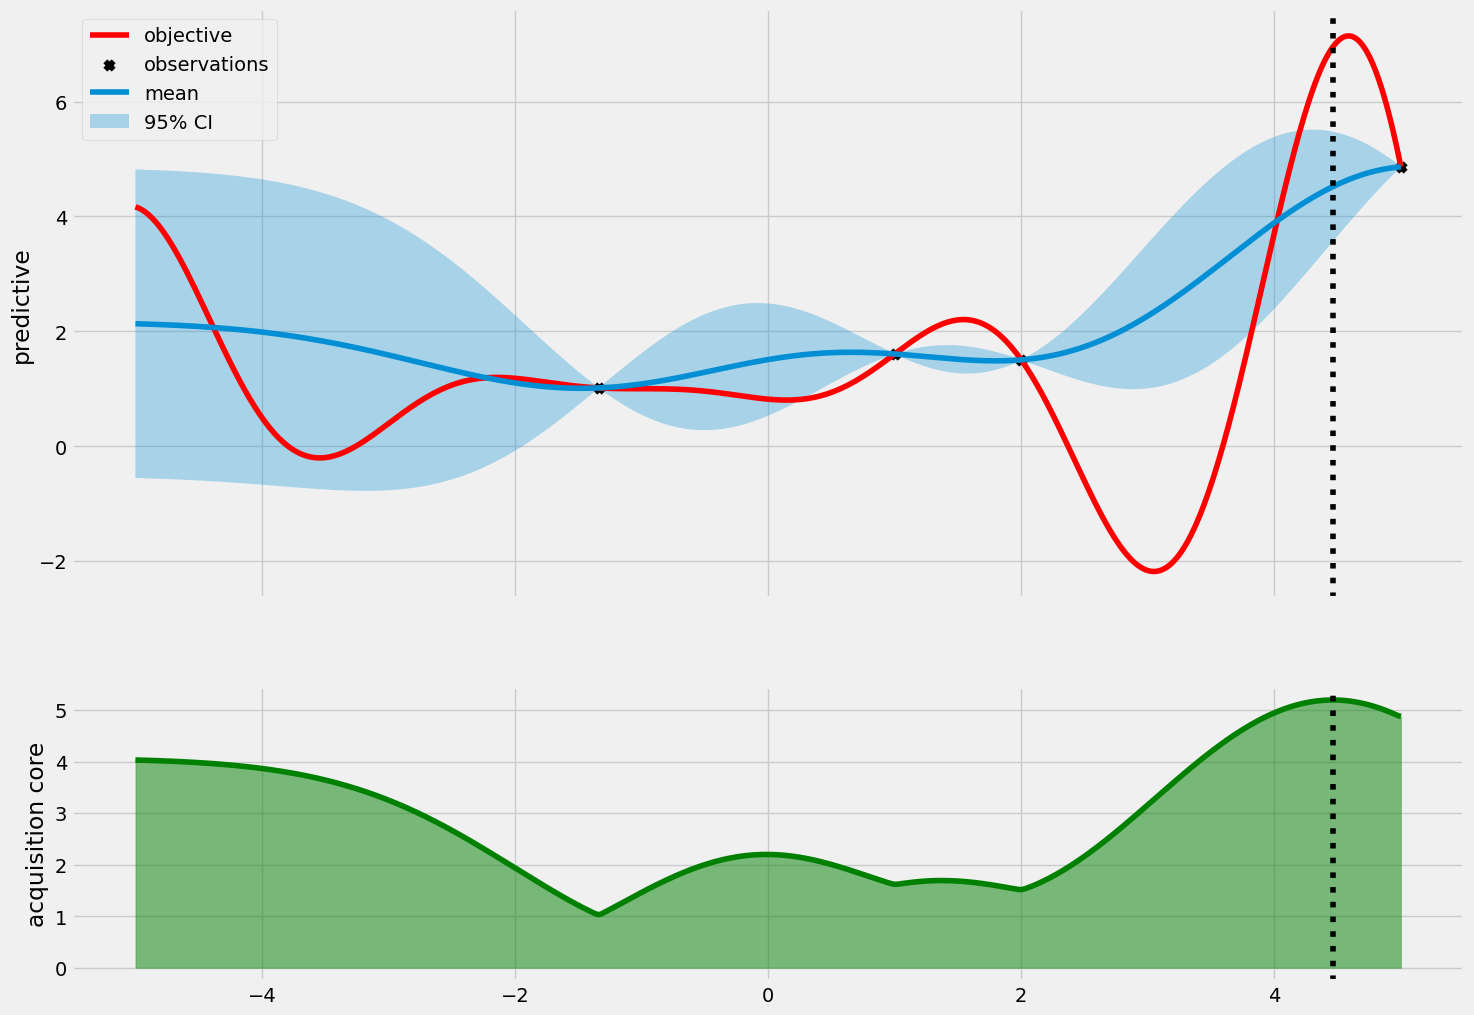

iteration 3
incumbent tensor([4.4621]) tensor(6.9516)


  0%|          | 0/500 [00:00<?, ?it/s]

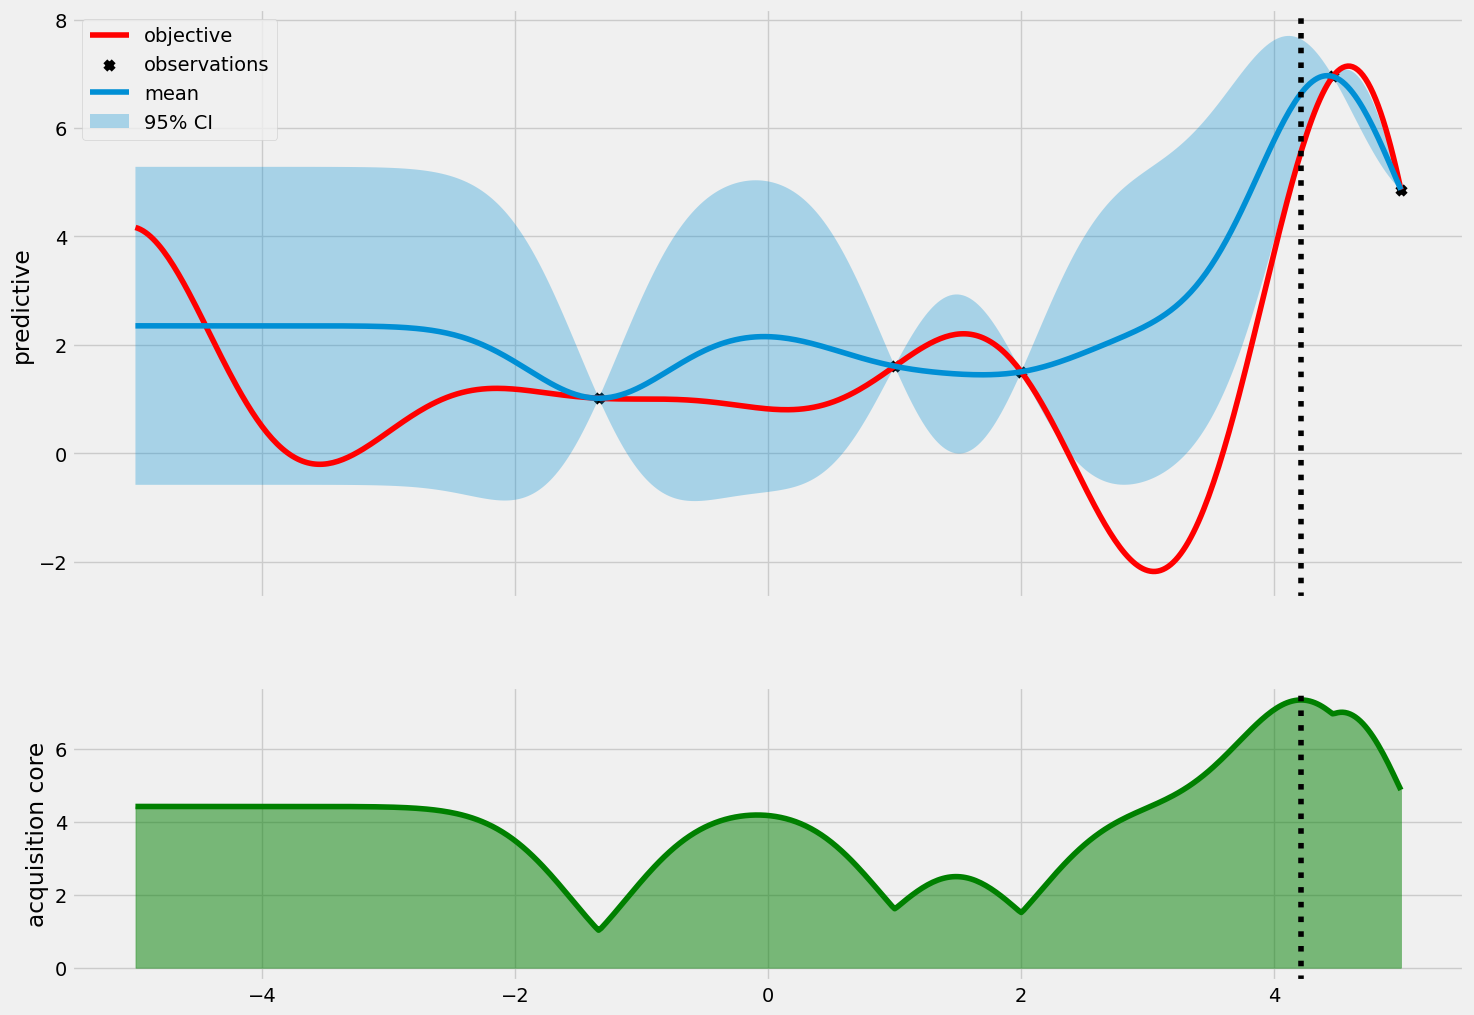

iteration 4
incumbent tensor([4.4621]) tensor(6.9516)


  0%|          | 0/500 [00:00<?, ?it/s]

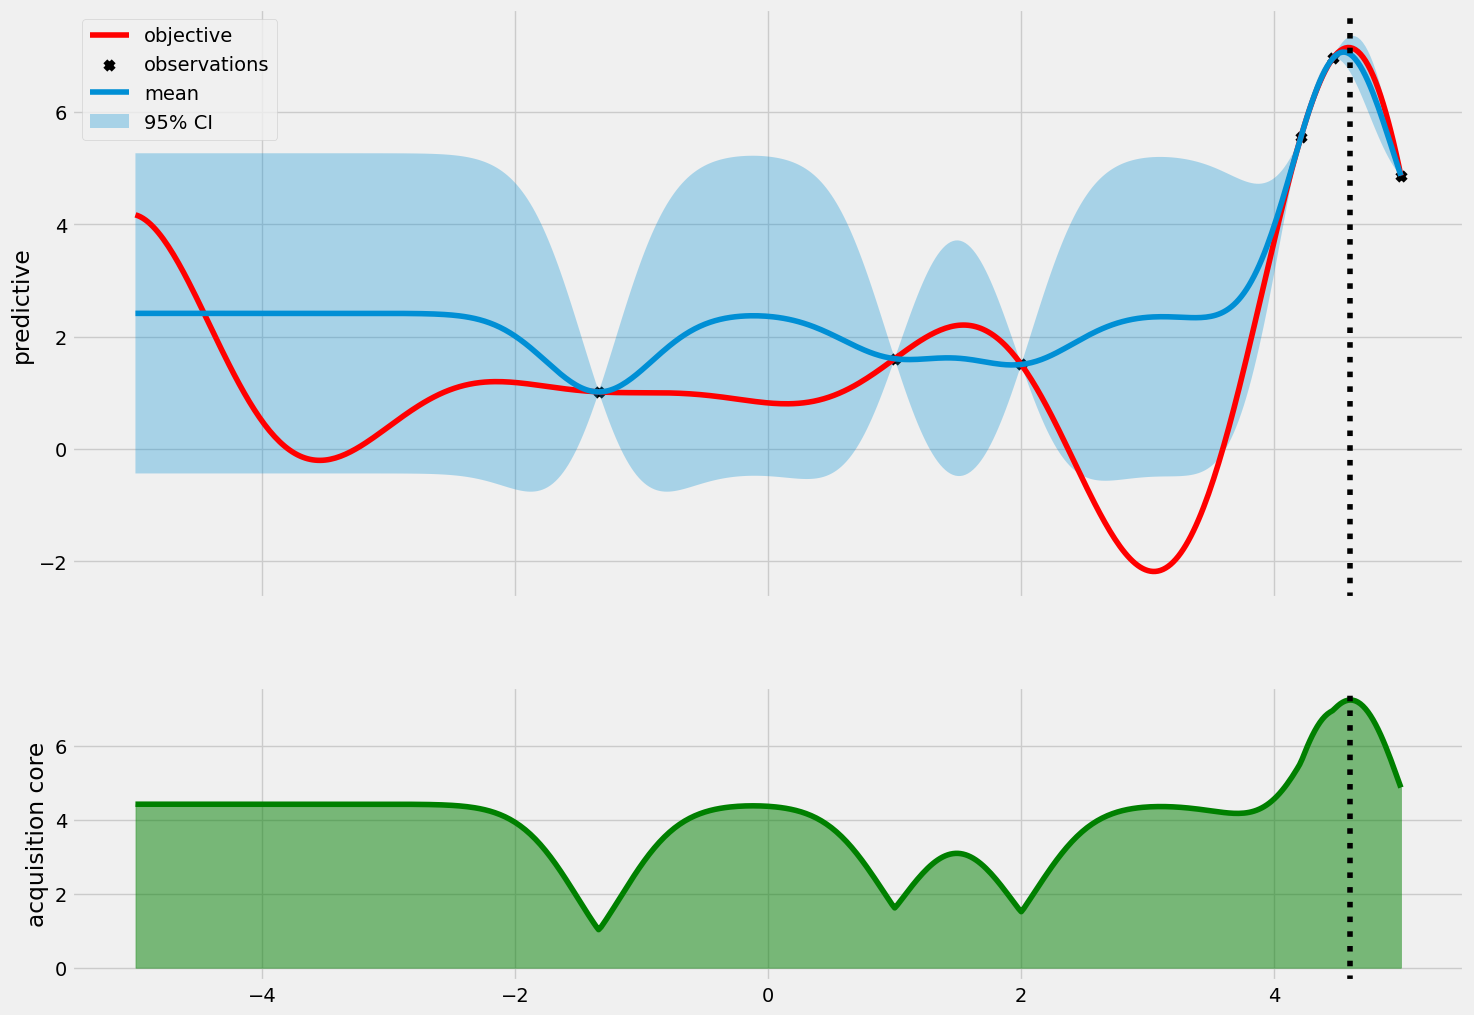

iteration 5
incumbent tensor([4.6016]) tensor(7.1408)


  0%|          | 0/500 [00:00<?, ?it/s]

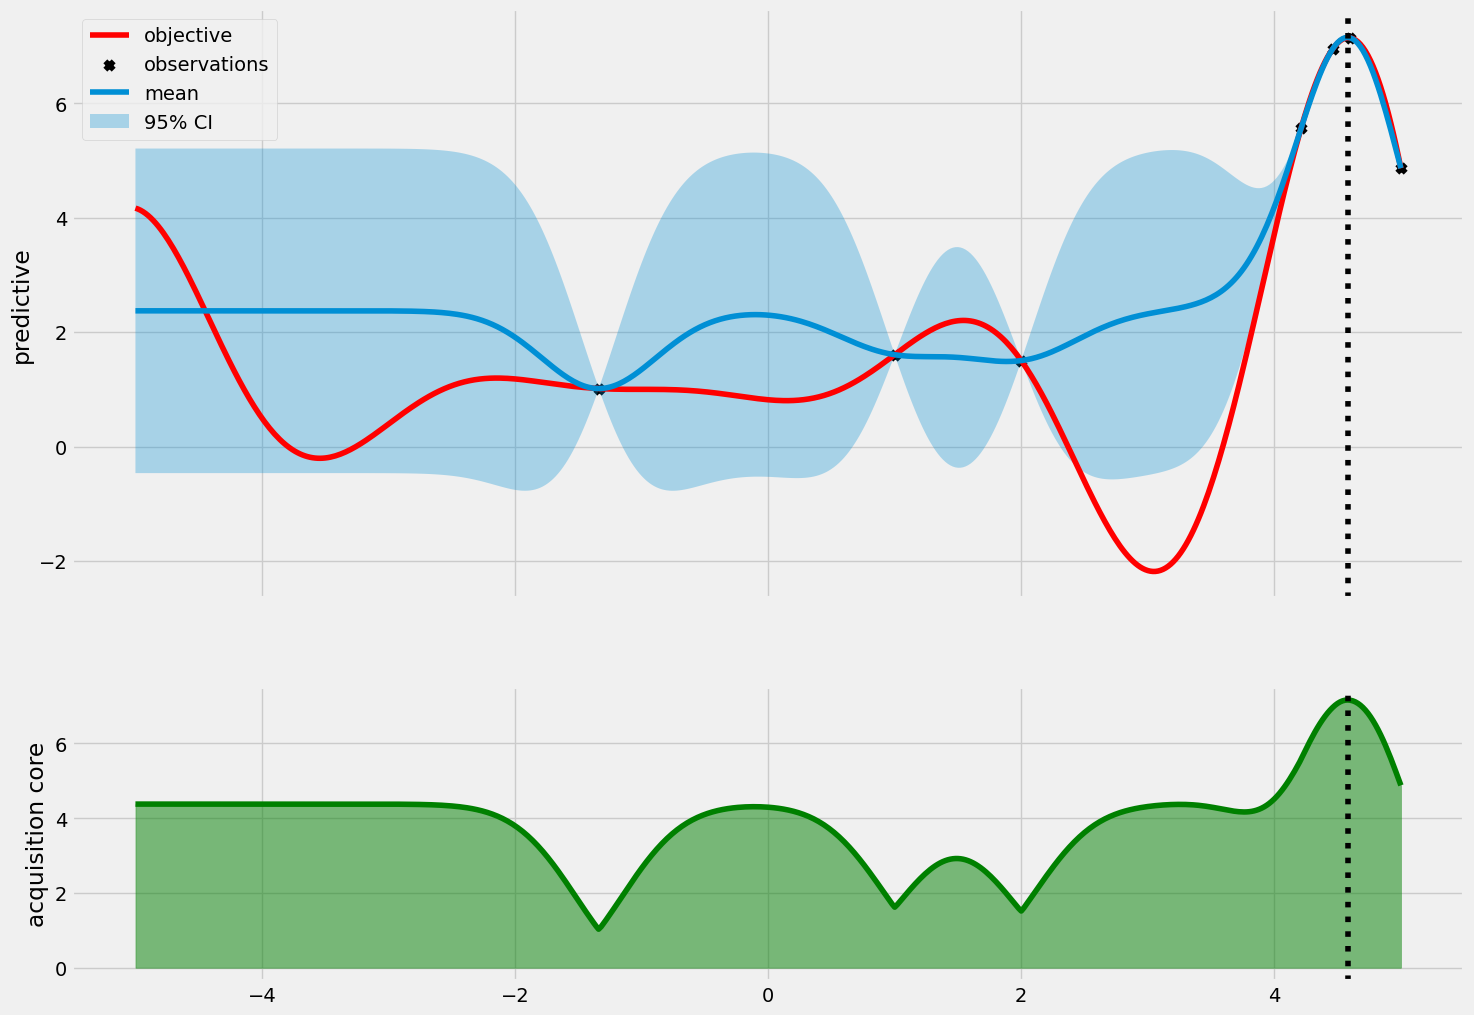

iteration 6
incumbent tensor([4.5790]) tensor(7.1431)


  0%|          | 0/500 [00:00<?, ?it/s]

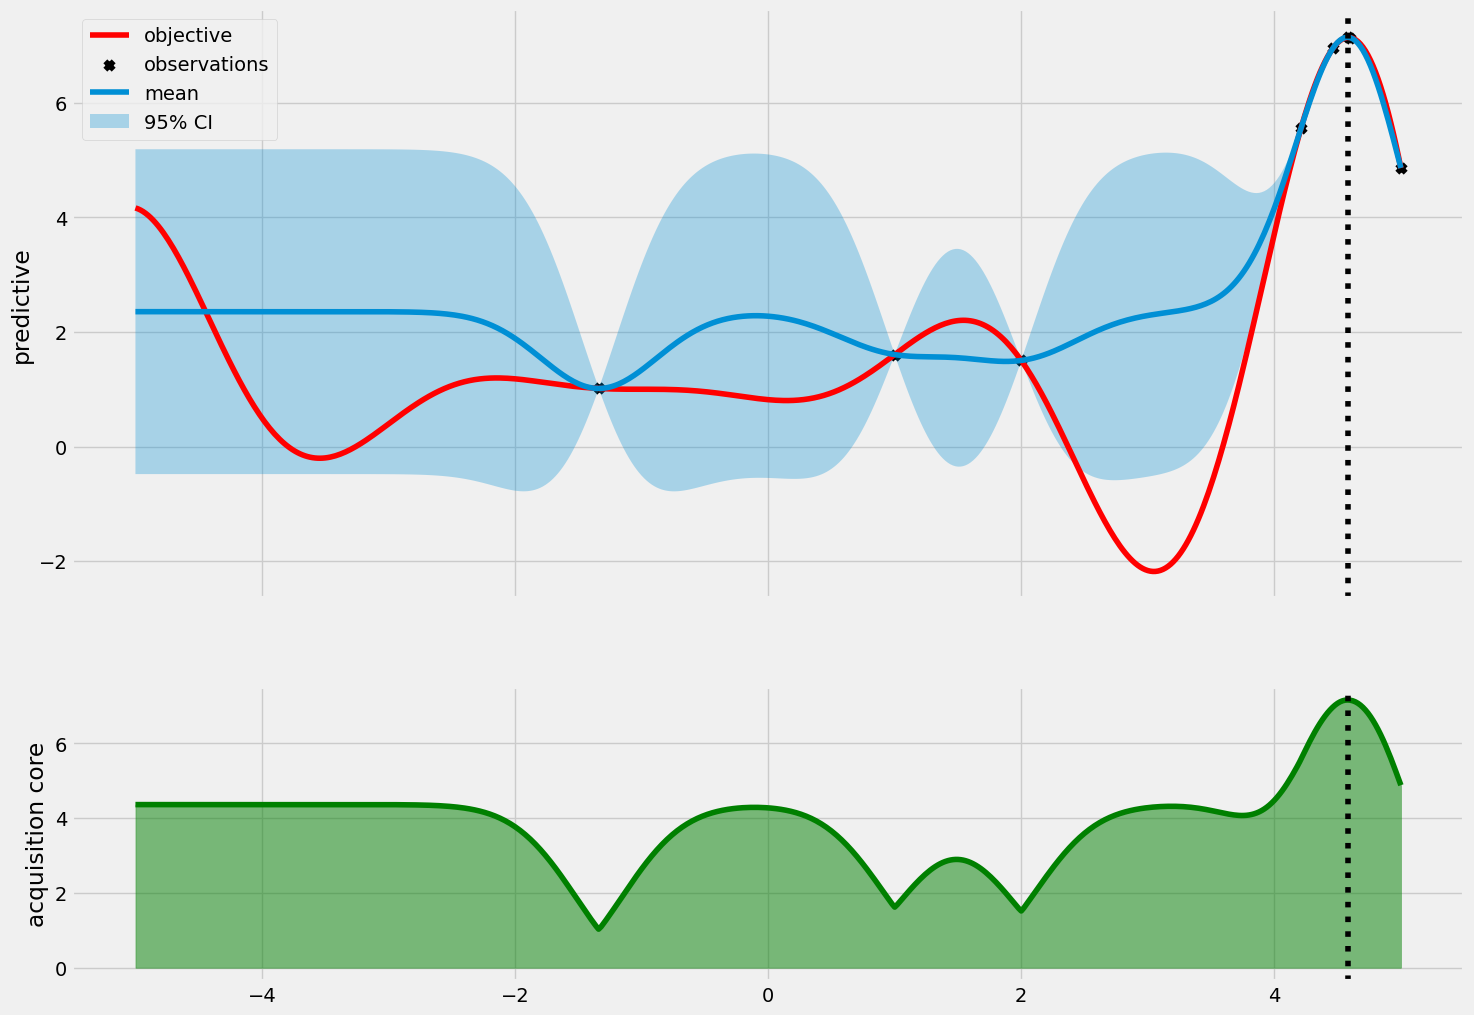

iteration 7
incumbent tensor([4.5790]) tensor(7.1431)


  0%|          | 0/500 [00:00<?, ?it/s]

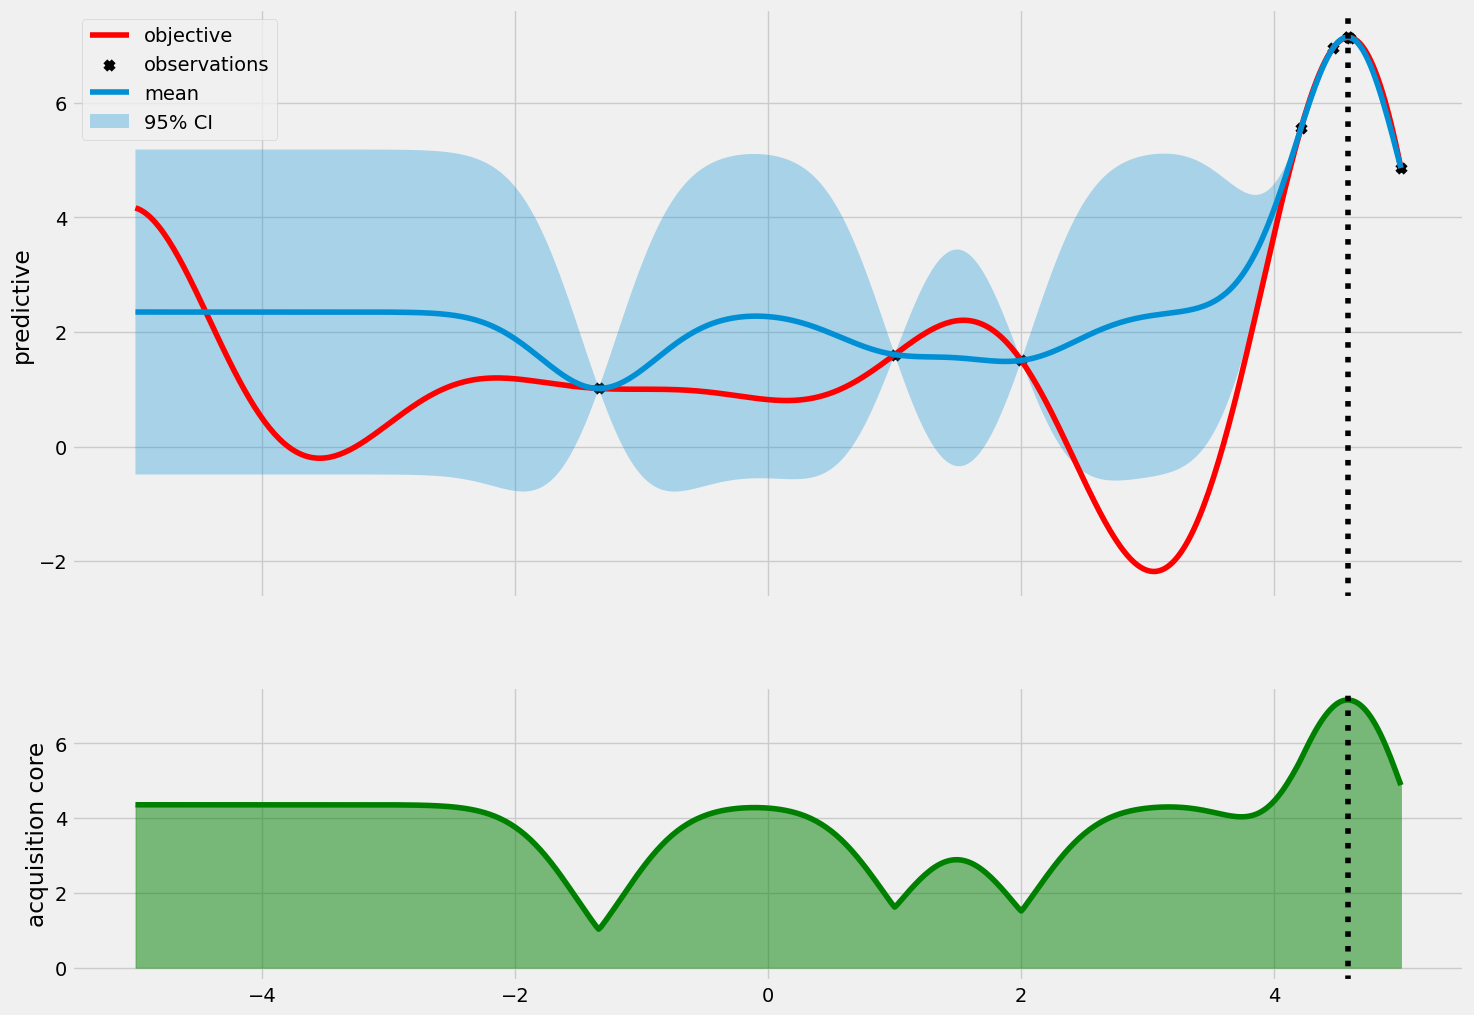

iteration 8
incumbent tensor([4.5790]) tensor(7.1431)


  0%|          | 0/500 [00:00<?, ?it/s]

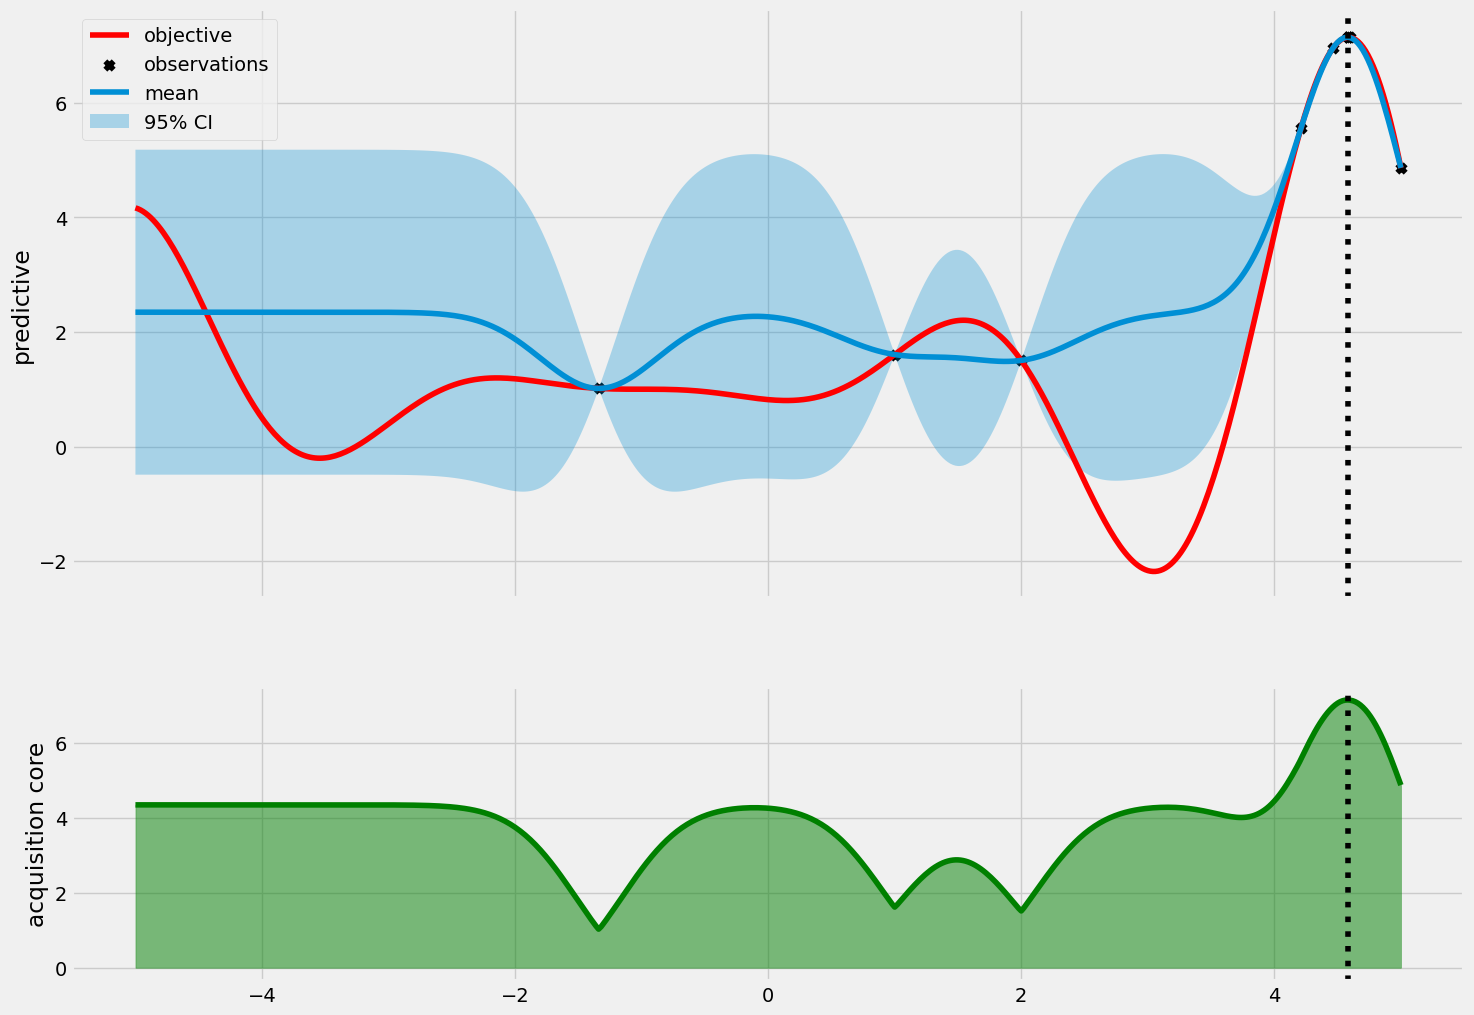

iteration 9
incumbent tensor([4.5790]) tensor(7.1431)


  0%|          | 0/500 [00:00<?, ?it/s]

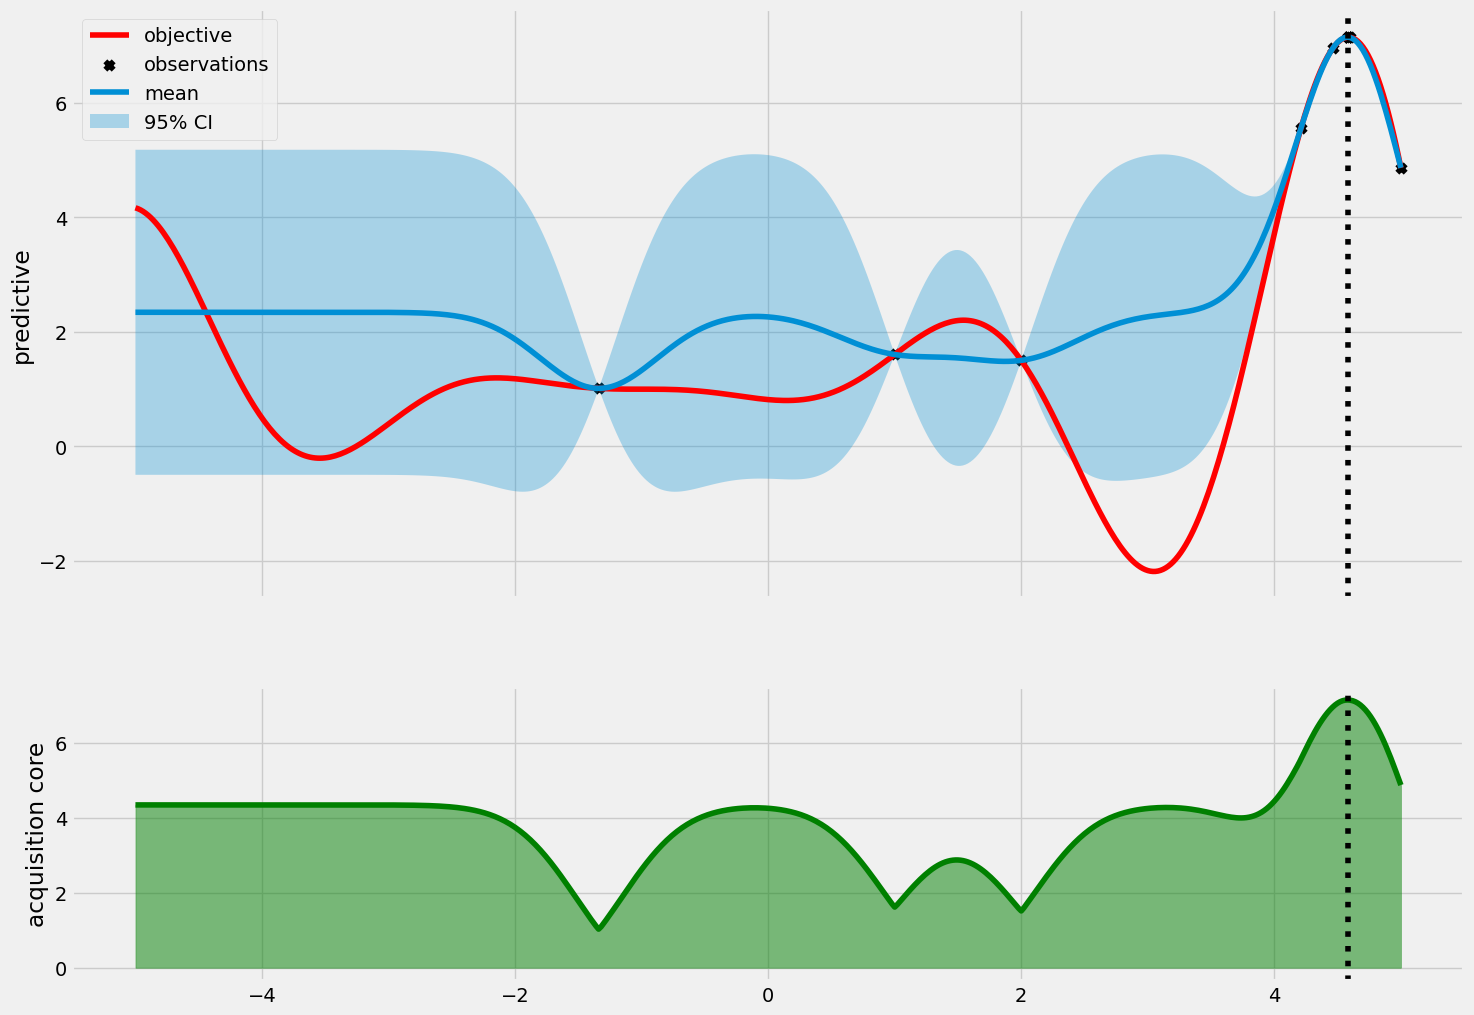

In [4]:
visualize_improvement("ucb", beta=2)

## Smart Sampling with Thompson policy sampling

In [5]:
xs = torch.linspace(-bound, bound, bound * 100 + 1).unsqueeze(1)
ys = forrester_1d(xs)

train_x = torch.tensor([[1.0], [2.0]])
train_y = forrester_1d(train_x)

num_candidates = 1000
num_queries = 10

torch.manual_seed(1)

for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    sobol = torch.quasirandom.SobolEngine(1, scramble=True)

    candidate_x = sobol.draw(num_candidates)
    candidate_x = 10 * candidate_x - 5

    model, likelihood = fit_gp_model(train_x, train_y)

    ts = botorch.generation.MaxPosteriorSampling(model, replacement=False)
    next_x = ts(candidate_x, num_samples=1)

    visualize_gp_belief_and_policy(
        model, likelihood, next_x=next_x, xs=xs, ys=ys, train_x=train_x, train_y=train_y
    )

    next_y = forrester_1d(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

NameError: name 'bound' is not defined